# Overfitting and Underfitting
**Overfitting**: occurs when a model is too complex for the data. It too closely models the training data, meaning it will be inaccurate when using *new data*. It happens when:
- There is not enough data to train on
- There is too much noise in the relationship between *x* and *y*
- Overfit models tend to exhibit high *variance* - small changes in the training set will result in changes in predictions errors without an obvious structure.

**Underfitting**: occurs when a model is too simple for the data. It does not approximate the generative process well. It happens when:
- There is plenty of data
- There is low noise and the model is too constrained to capture this noise
- Underfit models tend to exhibit high *bias* - they systematically make errors with changes in the training set (they ignore some aspects of the data).

There is a clear tradeoff between overfitting and underfitting.

## Training Error and Testing Error
In the prior module's notebooks, we used `predict` on our model and `cross_validate` to test the accuracy. They are testing two fundamental different types of errors:

**Training Error**: the error that occurs on the training set. This is the error we get from using `cross_validate`.

**Testing Error**: the error that occurs on predicting new data from the testing set. This is the error we get from using `predict` or `score`.

This underscores the importance of cross-validation. We are able to get an estimate of the variability of the model's generalization performance through various different splits of the data.

## Sources of Overfitting and Underfitting
When examining the overfitting-underfitting tradeoff, we can examine two primary causes:
1. **Complexity**: suppose we use a polynomial linear function to describe our data. As we increase the complexity, the train error will decrease as it starts to "memorize" the training data, but test error will rapidly increase.

![Complexity](complexity.png)

2. **Data**: now with a fixed complexity for our function, we can see that with an increase in the number of training samples, the train and test error converge. Beyond a certain point, there are diminishing returns. This also gives way to **Bayes error rate**, the error of the best model trained on unlimited data (i.e., we cannot do better).

![Samples](sample.png)

## Complexity in Detail

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

To better understand the generalization performance of our model, we compare training and testing error with `cross_validate`.

In [5]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit, LearningCurveDisplay

cv = ShuffleSplit(
    n_splits=30,
    test_size=0.2,
    random_state=42,
)
cv_result = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=2,
)
cv_result = pd.DataFrame(cv_result)

In [6]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_result[["train_score", "test_score"]]

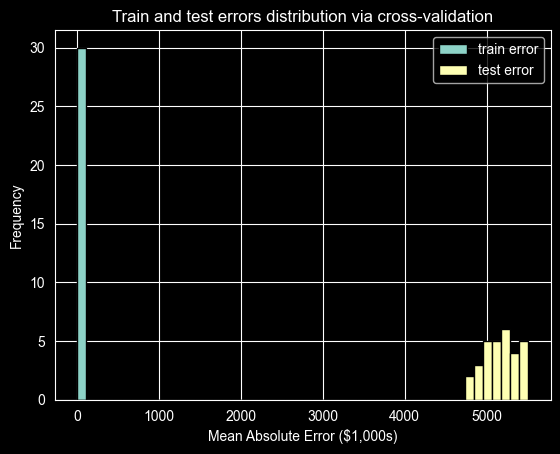

In [7]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean Absolute Error ($1,000s)")
_ = plt.title("Train and test errors distribution via cross-validation")

By plotting the distribution of the training and testing errors, we can see if the model is overfitting, underfitting, or both.

We can see that the small training error indicates we are not underfitting, however, the significantly large testing error signals that the model is overfitting (i.e., memorized the data).

### Validation Curve
The validation curve showcases the training and testing error with changes in a hyperparemeter.

**Hyperparameters**: parameters that potentially impact the result of the learning and subsequent predictions of a predictor. For example, the degree of a polynomial, the number of neighbours in a KNN, etc.

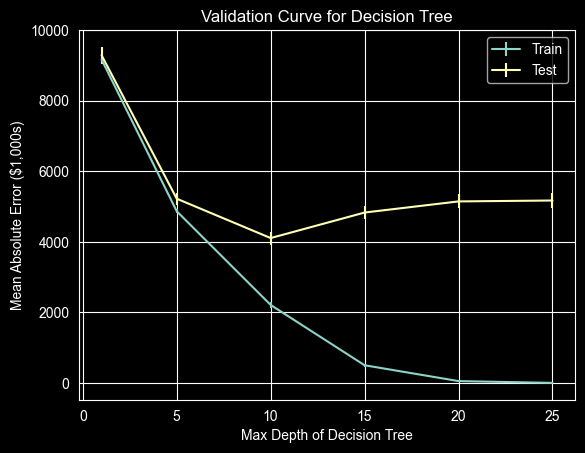

In [8]:
import numpy as np
from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_squared_error",
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=2
)
_ = disp.ax_.set(
    xlabel="Max Depth of Decision Tree",
    ylabel="Mean Absolute Error ($1,000s)",
    title="Validation Curve for Decision Tree"
)

As can be seen by the validation curve, for `max_depth < 10`, the decision tree underfits as the model is too constained. For `max_depth > 10`, the decision tree overfits as the model creates decisions specifically for noisy samples. Around `max_depth = 10` we receive the best generalization performance.

## Sample Size in Detail

### Learning Curve
To understand the impact of the number of samples available for training on the generalization performance, it is possible to synthetically reduce the number of samples used to train, then check train and test errors.

Similar to the validation curve, these can be plotted on a curve called the learning curve by changing the number of samples instead of a hyperparameter.

In [9]:
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [10]:
cv = ShuffleSplit(
    n_splits=30,
    test_size=0.2
)

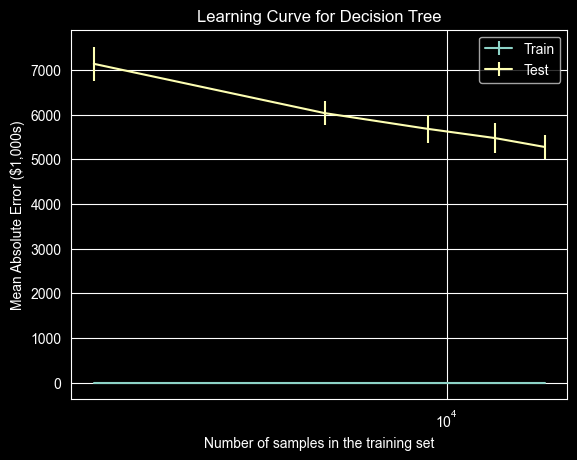

In [12]:
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    score_type="both",
    scoring="neg_mean_squared_error",
    negate_score=True,
    score_name="Mean Absolute Error ($1,000s)",
    std_display_style="errorbar",
    n_jobs=2
)
_ = display.ax_.set(
    xscale="log",
    title="Learning Curve for Decision Tree"
)

This model is clearly overfitting the training data, but from the testing data, as more samples are added, the lower the error becomes.